### Описание данных

Описание данных

1. **VendorID** - Код поставщика

(1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.)

2. **tpep_pickup_datetime** - Время, когда таксометр был включен  

3. **tpep_dropoff_datetime** - Время, когда таксометр был отключен 

4. **Passenger_count** Количество пассажиров в поездке

5. **Trip_distance** Прошедшее расстояние в милях, указанное в таксометре

6. **PULocationID** Координаты, где был включен таксометр

7. **DOLocationID** Координаты, где был отключен таксометр

8. **RateCodeID** Последний код тарифа

1= Standard rate
2=JFK
3=Newark
4=Nassau or Westchester
5=Negotiated fare
6=Group ride

9. **Store_and_fwd_flag** Этот флаг указывает, хранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику, иначе говоря, «сохранить и пересылать», поскольку у транспортного средства не было соединения с сервером.

Y= store and forward trip
N= not a store and forward trip

10. **Payment_type** Как клиент оплатил такси

1= Credit card
2= Cash
3= No charge
4= Dispute
5= Unknown
6= Voided trip

11. **Fare_amount** Стоимость поездки рассчитанная по таксометру

12. **Extra** Разные дополнения и доплаты. В настоящее время это включает только 0,50 доллара США и 1 доллар США в час пик и оплату за ночь.

13. **MTA_tax** Налог MTA в размере 0,50 доллара США, который автоматически взимается в зависимости от используемой измеренной ставки.

14. **Improvement_surcharge** Доплата за улучшение в размере 0,30 доллара за поездки при спуске флага. Надбавка за благоустройство начала взиматься в 2015 году.

15. **Tip_amount** Сумма чаевых - это поле автоматически заполняется для чаевых по кредитной карте. Денежные чаевые не включены.

16. **Tolls_amount** Общая сумма всех оплаченных дорожных сборов за поездку.

17. **Total_amount** Общая сумма взимается с пассажиров. Не включает денежные чаевые.



### Задание 3 неделя

1. Выберите одну из зон среди отобранных на прошлой неделе, возьмите по ней все подготовленные данные о количестве поездок. Не используйте данные за последний имеющийся месяц — июнь 2016! Создайте регрессионные признаки для учёта сезонностей и трендов.
2. Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, сделайте регрессию целевого признака — количества поездок — на построенные признаки. Посмотрите на остатки регрессии. Если регрессионные признаки подобраны идеально, то в них должна остаться только внутрисуточная сезонность. Вслепую идеально подобрать признаки вам вряд ли удастся, так что в остатках вы, скорее всего, увидите много интересного, в том числе праздники, аномалии, тренды и многое другое.
3. Чтобы подобрать значения гиперпараметров ARIMA, попробуйте сделать ряд остатков стационарным. Если необходимо, сделайте несколько дифференцирований. Из-за большого количества аномальных дней (праздники и т.д.) вряд ли вам удастся сделать так, что критерий Дики-Фуллера не будет отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования ориентируйтесь в первую очередь на результат STL-декомпозиции.
4. Постройте ACF и PACF полученного ряда остатков (возможно, продифференцированных) с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год), подберите по ним начальные приближения для параметров p, q, P, Qp,q,P,Q. Используйте эти начальные приближения при переборе моделей ARIMA исходного ряда, не забывая подавать функции SARIMAX регрессионные признаки в качестве параметра exog.
5. Выберите оптимальную по AIC модель; постройте график исходного ряда и нарисуйте поверх предсказания выбранной модели. Если модель плохо описывает данные, попробуйте увеличить количество синусов и косинусов KK или поменять порядки дифференцирования.
6. Проанализируйте качество построенной модели. Опишите, в какие периоды она плохо описывает данные? Можно ли заранее предсказать её поведение в такие периоды и улучшить тем самым прогноз? Если да, попробуйте создать для таких периодов регрессионные признаки и вернитесь к пункту 2.
7. Загрузите ноутбук в форму.

### Импорт библиотек

In [3]:
pip install geojson

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import binned_statistic_2d
#from google.colab import drive
import matplotlib.pyplot as plt
import folium
import geojson
import datetime
import warnings
import statsmodels.api as sm
from scipy import stats
from itertools import product
from sklearn import linear_model, model_selection, metrics
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

 
warnings.filterwarnings("ignore")

"""
drive.mount('/final_project/')
%cd "/final_project/MyDrive/final_project"
%ls
"""

'\ndrive.mount(\'/final_project/\')\n%cd "/final_project/MyDrive/final_project"\n%ls\n'

### функции

In [6]:
def data_preprocessing(file):
    # читаем файл с данными
    data = pd.read_csv(file, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

    # удаляем поездки с нулевой длительностью
    data['trip_duration'] = data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']
    data = data[data['tpep_dropoff_datetime'] != data['tpep_pickup_datetime']]

    # удаляем поездки с нулевым количеством пассажиров
    data = data[data.passenger_count != 0]

    # удаляем поездки с нулевым расстояние поездки
    data = data[data.trip_distance != 0]

    # удаляем поездки с кривыми датами
    data = data[(data.tpep_pickup_datetime >= get_date(file)[0]) & (data.tpep_pickup_datetime < get_date(file)[1])]

    # добавляем столбец с часом
    data['tpep_pickup_hour'] = data.tpep_pickup_datetime.map(lambda x: x.floor(freq='h'))

    # создаем агрегированную таблицу и сохраняем её
    agg_table = pd.pivot_table(data, values='VendorID', index='tpep_pickup_hour', columns='PULocationID', aggfunc='count')
    agg_table.to_csv('agg_' + file, sep=';')

def get_date(file):
    month = int(file[21:23])
    if month == 12:
        return datetime.datetime(2020, month, 1), datetime.datetime(2021, 1, 1)
    return datetime.datetime(2020, month, 1), datetime.datetime(2020, month + 1, 1)

def get_most_crowded_zone(data):
    return data.sum(axis=0).sort_values().index[-1]

def add_features(data, k, holidays):
    data['const'] = 1
    data['lin'] = np.arange(1, data.shape[0]+1)
    data['is_holiday'] = [x in holidays for x in data.index.floor('d')]
    features_columns = ['const', 'lin', 'is_holiday']
    features_columns += month_features(data)
    features_columns += weekday_features(data)
    features_columns += hour_features(data)
    for i in range(1, k+1):
        week_sin_col = f'week_sin_{i}'
        week_cos_col = f'week_cos_{i}'
        data[week_sin_col] = np.sin(np.array(data['lin'] * 2 * np.pi * i / 168))
        data[week_cos_col] = np.cos(np.array(data['lin'] * 2 * np.pi * i / 168))
        features_columns += [week_sin_col, week_cos_col]
    return features_columns

def get_reg_pred(data, features_columns):
    train_data = np.array(data[features_columns])
    train_labels = np.array(data['trips'])
    
    model = linear_model.LinearRegression()
    model.fit(train_data, train_labels)
    
    preds = model.predict(data[features_columns])
    
    data['reg_pred'] = preds
    data['reg_resid'] = data['trips'] - preds
    
    return preds

def month_features(data):
    features_columns = []
    for x in range(1, 13):
        col_name = f'month{x}'
        data[col_name] = [data.index.month == x][0]
        features_columns.append(col_name)
    return features_columns

def hour_features(data):
    features_columns = []
    for x in range(0, 24):
        col_name = f'hour{x}'
        data[col_name] = [data.index.hour == x][0]
        features_columns.append(col_name)
    return features_columns

def weekday_features(data):
    features_columns = []
    for x in range(0, 7):
        col_name = f'weekday{x}'
        data[col_name] = [data.index.weekday == x][0]
        features_columns.append(col_name)
    return features_columns

### Попробуем визуализировать данные за 2020 год, вместо 2016

Загрузим geojson, который содержит координаты и номера зон

In [7]:
with open('NYC Taxi Zones.geojson') as f:
    gj = geojson.load(f)

files = ['yellow_tripdata_2020-01.csv',
         'yellow_tripdata_2020-02.csv',
         'yellow_tripdata_2020-03.csv',
         'yellow_tripdata_2020-04.csv',
         'yellow_tripdata_2020-05.csv',
         'yellow_tripdata_2020-06.csv',
         'yellow_tripdata_2020-07.csv',
         'yellow_tripdata_2020-08.csv',
         'yellow_tripdata_2020-09.csv',
         'yellow_tripdata_2020-10.csv',
         'yellow_tripdata_2020-11.csv',
         'yellow_tripdata_2020-12.csv']

Загружаем и проводим предобработку данных.

Сгруппировываем выгрузку по количеству вызовов такси в каждом часе.

Рисуем карту с новыми зонами в НьюЙорке

In [10]:
"""
for file in files:
    print(f'start in {datetime.datetime.now()} with file: {file}')
    data_preprocessing(file)
"""

# рисуем карту
agg_table = pd.read_csv('agg_yellow_tripdata_2020-12.csv', sep=';')
center_ny = [np.mean([40.49612, 40.91553]), np.mean([-74.25559, -73.70001])]
m = folium.Map(location=center_ny, width=500, height=500, zoom_start=11)
folium.Choropleth(geo_data=gj,
                  data=agg_table.sum(axis=0)[1:].reset_index().rename(columns={'index': 'region', 0: 'count'}), 
                  columns=['region', 'count'],
                  key_on='feature.properties.location_id',
                  bins=6,
                  fill_color='YlOrRd',
                  nan_fill_color='white', 
                  nan_fill_opacity=0.7,
                  fill_opacity=0.8, 
                  line_opacity=0.1,
                  legend_name='Количество заказов такси').add_to(m)

m

AttributeError: module 'folium' has no attribute 'Choropleth'

Визуализировать Нью-Йорк с готовыми координатами зон даже проще и выглядит карта намного лучше.

### Объединяем сгрупированные файлы за весь 2020 год, полученные на второй неделе

Для анализа возьмем регион с самым большим количеством заказов такси. 

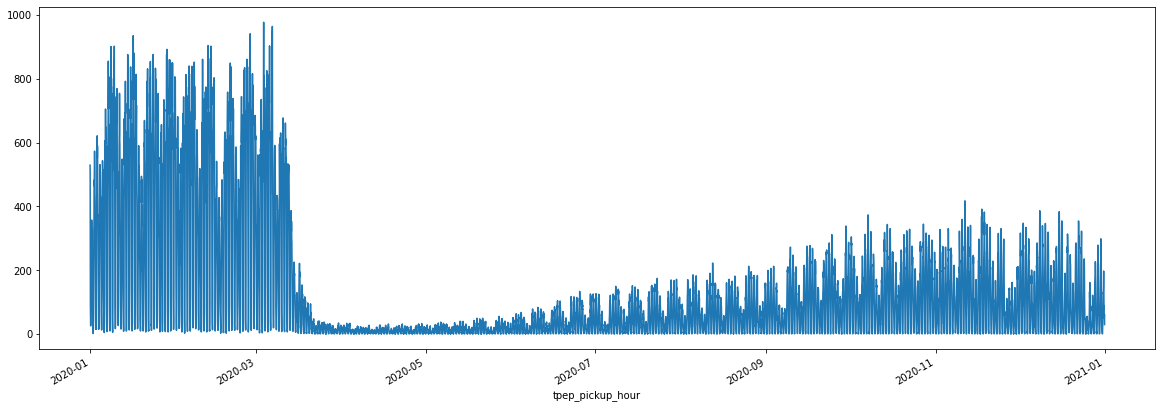

In [6]:
files_agg = ['agg_yellow_tripdata_2020-01.csv',
         'agg_yellow_tripdata_2020-02.csv',
         'agg_yellow_tripdata_2020-03.csv',
         'agg_yellow_tripdata_2020-04.csv',
         'agg_yellow_tripdata_2020-05.csv',
         'agg_yellow_tripdata_2020-06.csv',
         'agg_yellow_tripdata_2020-07.csv',
         'agg_yellow_tripdata_2020-08.csv',
         'agg_yellow_tripdata_2020-09.csv',
         'agg_yellow_tripdata_2020-10.csv',
         'agg_yellow_tripdata_2020-11.csv',
         'agg_yellow_tripdata_2020-12.csv']

# получаем общий сгруппированный файл
data = pd.read_csv('agg_yellow_tripdata_2020-01.csv', index_col=['tpep_pickup_hour'], sep=';', parse_dates=['tpep_pickup_hour'])
for file in files_agg[1:]:
  data = pd.concat([data, pd.read_csv(file, sep=';', index_col=['tpep_pickup_hour'], parse_dates=['tpep_pickup_hour'])])

# выбираем зону с самым большим количеством поездок
zone = get_most_crowded_zone(data)
data = data[[zone]]
data.rename(columns={zone: 'trips'}, inplace=True)
data.trips.fillna(value=0, inplace=True)

# визуализируем количество поедок в 2020 году
plt.figure(figsize=(20,7))
data.trips.plot()
plt.show()

Заметно, что начиная с марта начинается очень резкий спад количества вызовов такси.

Убираем начало 2020 года из данных для анализа

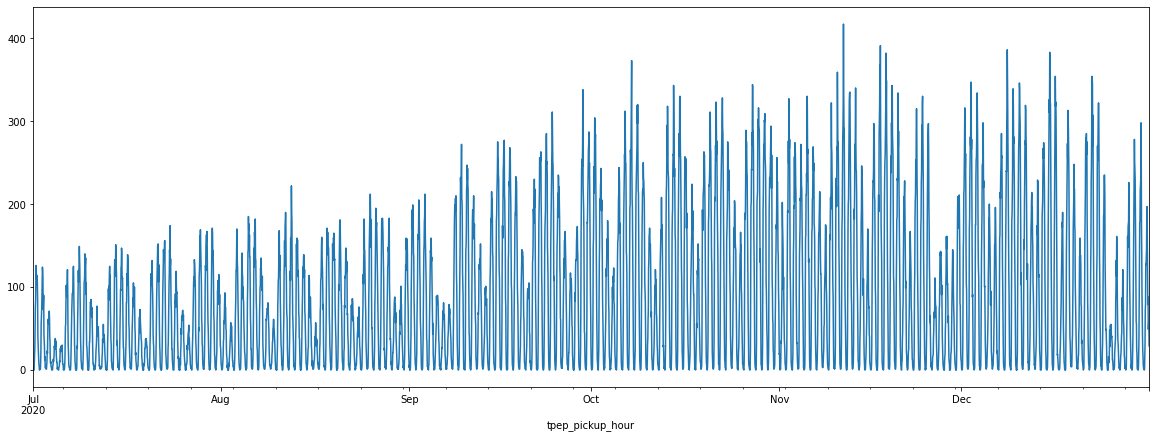

In [7]:
# оставляем данные с июля 2020
data = data[data.index >= datetime.datetime(2020, 7, 1)]
# визуализируем количество поедок начиная с июля 2020 года
plt.figure(figsize=(20,7))
data.trips.plot()
plt.show()

### Добавляем признаки и составляем линейную регрессию

Создаем признаки для линейно регресси:
1. Функция синусов и косинусов из описания к задаче
2. Признак часа (от 0 до 23). true или false для каждого объекта
3. Признак дня недели (от 0 до 6). true или false для каждого объект
4. Признак месяца (от 1 до 12). true или false для каждого объекта
5. Признак праздничного дня (из pandas.tseries.holiday)



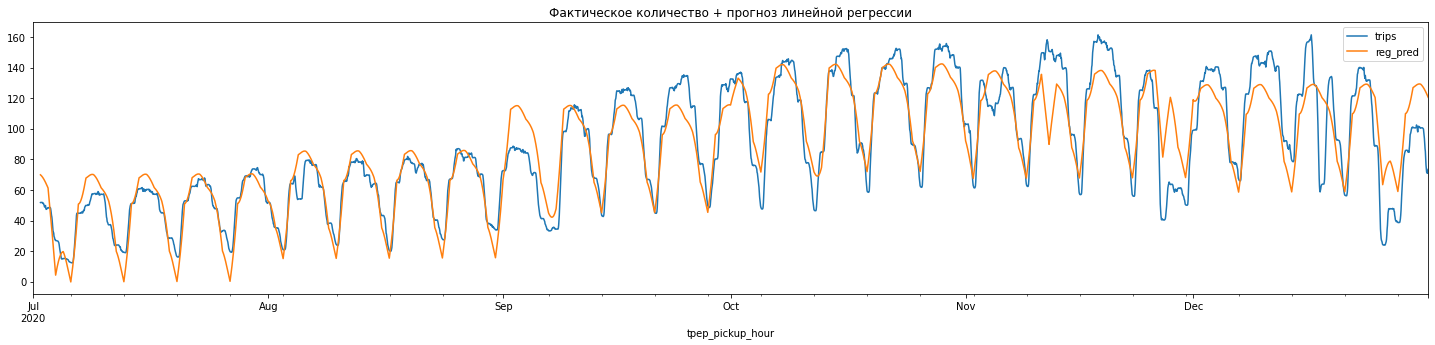

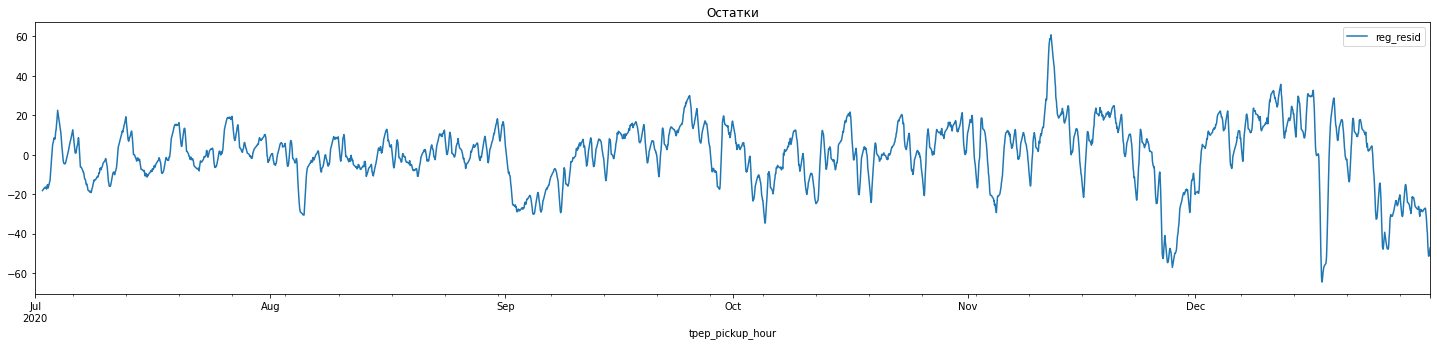

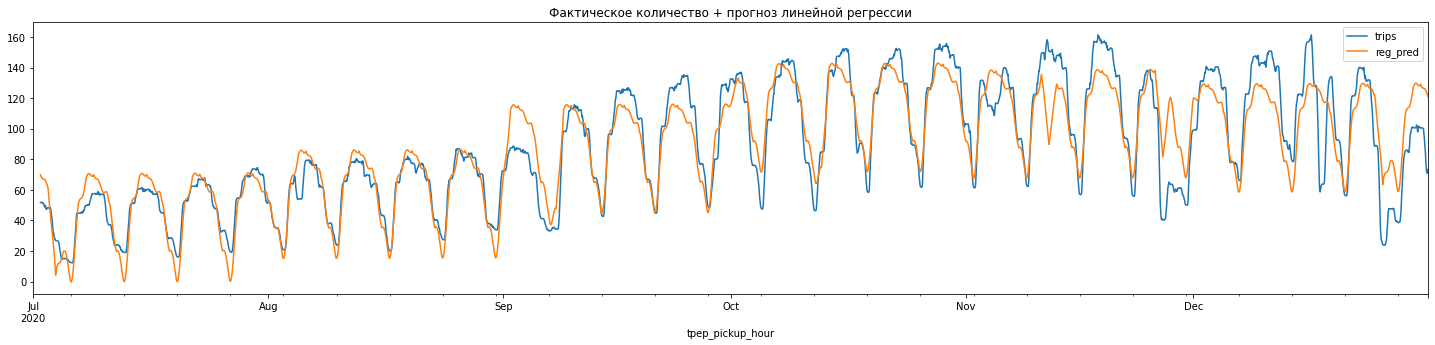

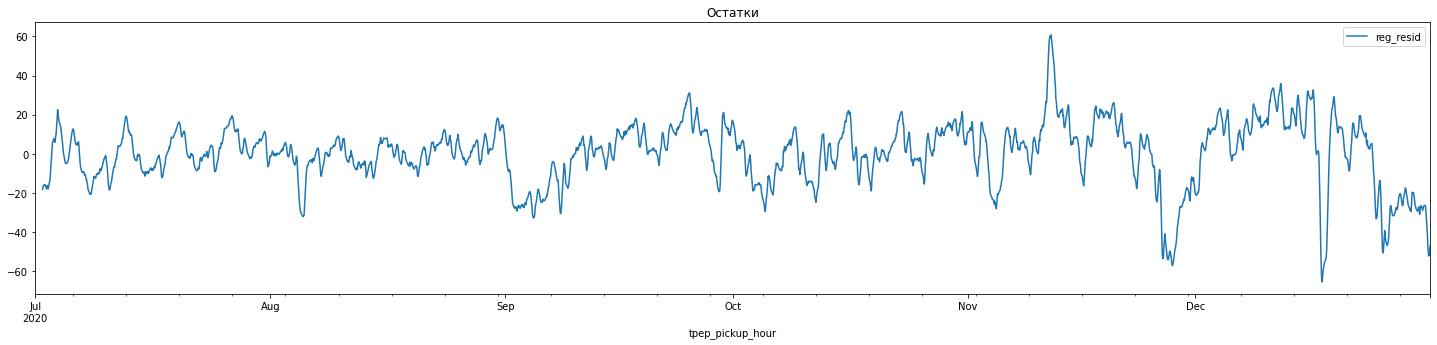

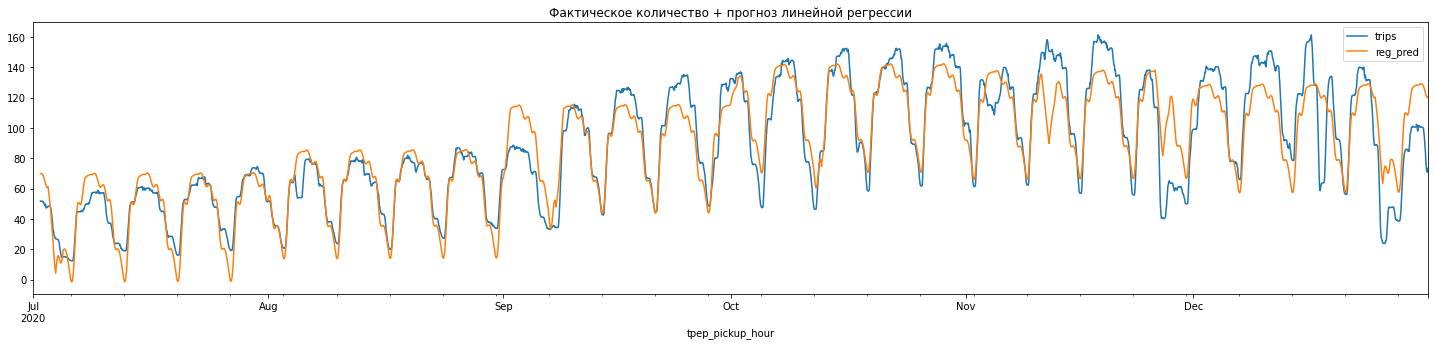

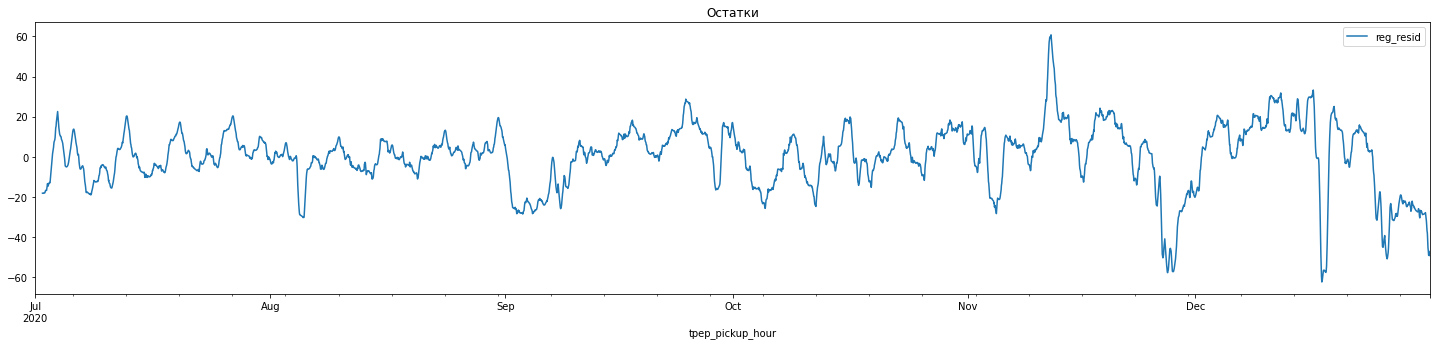

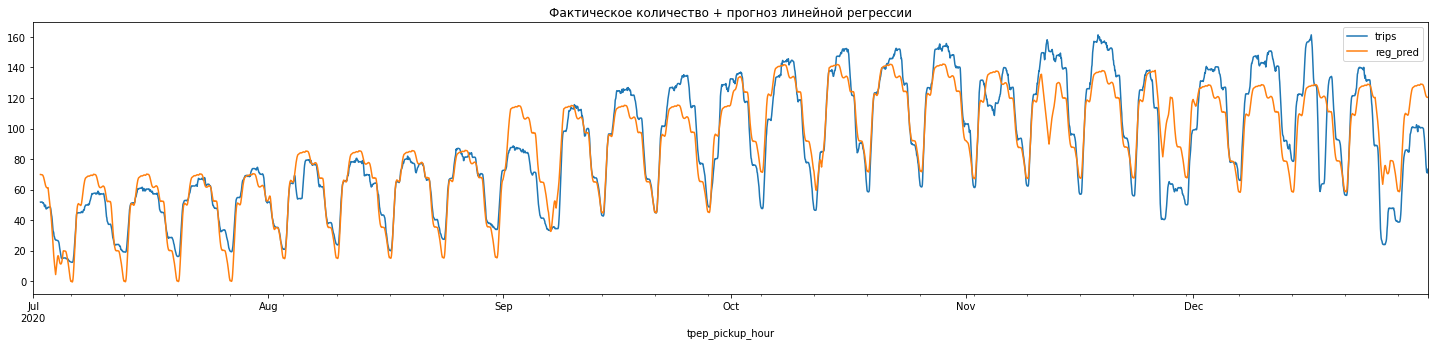

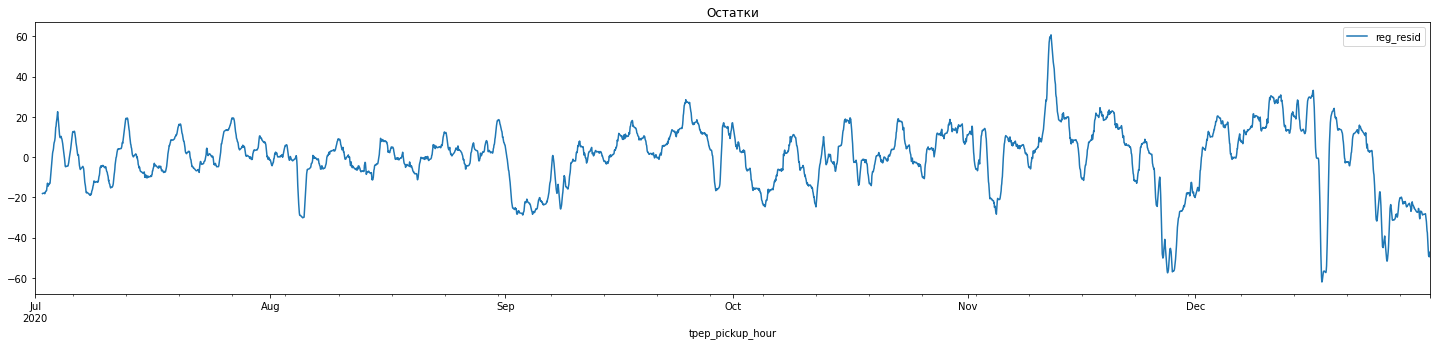

In [31]:
K = [2, 5, 10, 20]
holidays = USFederalHolidayCalendar().holidays(start=datetime.datetime(2020, 1, 1), end=datetime.datetime(2021, 1, 1))

for k in K:
    features_columns = add_features(data, k, holidays)
    reg_pred = get_reg_pred(data, features_columns)
    
    # Рисуем график среднедневного количества заказов (через pd.DataFrame.rolling)
    plt.figure(figsize=(25, 5))
    data['trips'].rolling(24).mean().plot(legend=True, title='Фактическое количество + прогноз линейной регрессии')
    data['reg_pred'].rolling(24).mean().plot(legend=True)
    ax.set_title(f'K = {k}')
    plt.show()

    plt.figure(figsize=(25, 5))
    data.reg_resid.rolling(24).mean().plot(title='Остатки', legend=True)
    plt.show()
    data.drop(columns=features_columns + ['reg_pred', 'reg_resid'], inplace=True)

Линейная регрессия с добавленными признаками очень плохо описывает график количества заказов такси.
Разница между коэффициентами К не заметна. Оставим К=2

### Подбираем параметры для модели ARIMA

In [32]:
features_columns = add_features(data, 2, holidays)
reg_pred = get_reg_pred(data, features_columns)
data.head(3)

,trips,fitted_values,resid,pred,const,lin,is_holiday,month1,month2,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12,weekday0,weekday1,weekday2,weekday3,weekday4,weekday5,weekday6,hour0,hour1,hour2,hour3,hour4,hour5,hour6,hour7,hour8,hour9,hour10,hour11,hour12,hour13,hour14,hour15,hour16,hour17,hour18,hour19,hour20,hour21,hour22,hour23,week_sin_1,week_cos_1,week_sin_2,week_cos_2,reg_pred,reg_resid
tpep_pickup_hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-01 00:00:00,3.0,0.000000,23.837433,-20.837433,1,1,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.037391,0.999301,0.074730,0.997204,-20.837433,23.837433
2020-07-01 01:00:00,1.0,23.835752,0.008509,0.991491,1,2,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.074730,0.997204,0.149042,0.988831,-22.844261,23.844261
2020-07-01 02:00:00,0.0,23.843583,1.090110,-1.090110,1,3,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.111964,0.993712,0.222521,0.974928,-24.933693,24.933693


Критерий Дики-Фуллера: p=0.000020


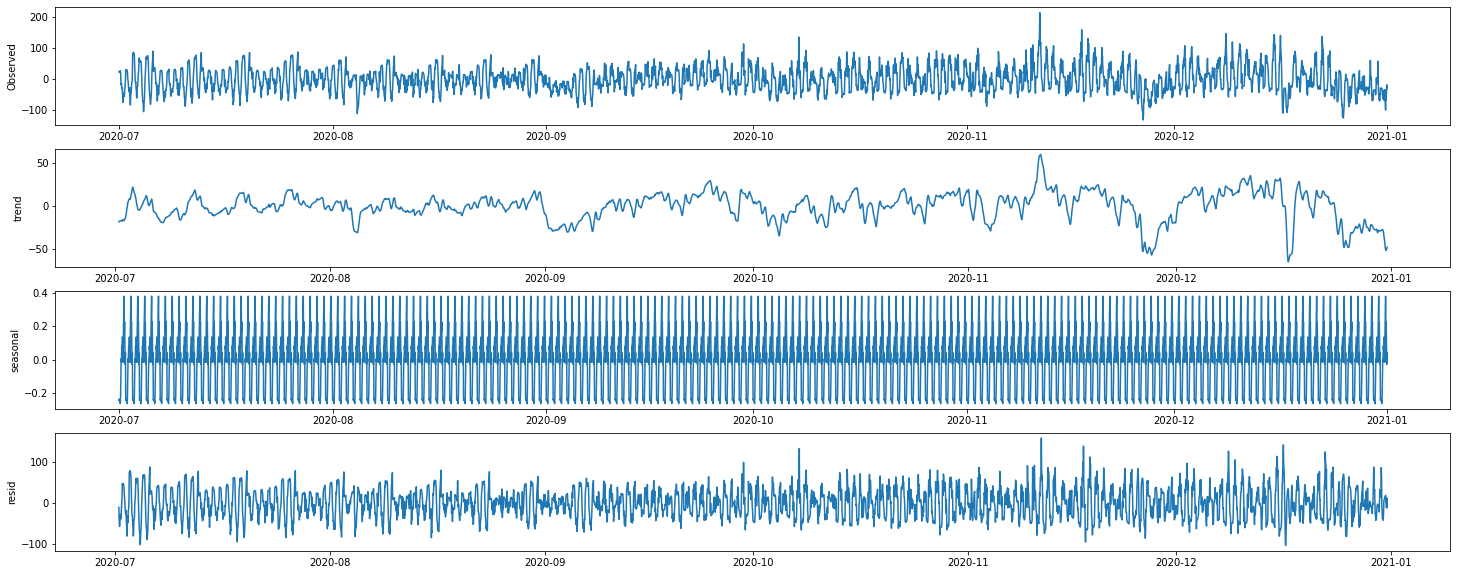

In [33]:
result = sm.tsa.seasonal_decompose(data.reg_resid, freq=24)
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(25,10))
axes[0].plot(result.observed)
axes[0].set(ylabel='Observed')
axes[1].plot(result.trend)
axes[1].set(ylabel='trend')
axes[2].plot(result.seasonal)
axes[2].set(ylabel='seasonal')
axes[3].plot(result.resid)  
axes[3].set(ylabel='resid') 
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.trips)[1])
plt.show()

Критерий Дики-Фуллера: p=0.000000


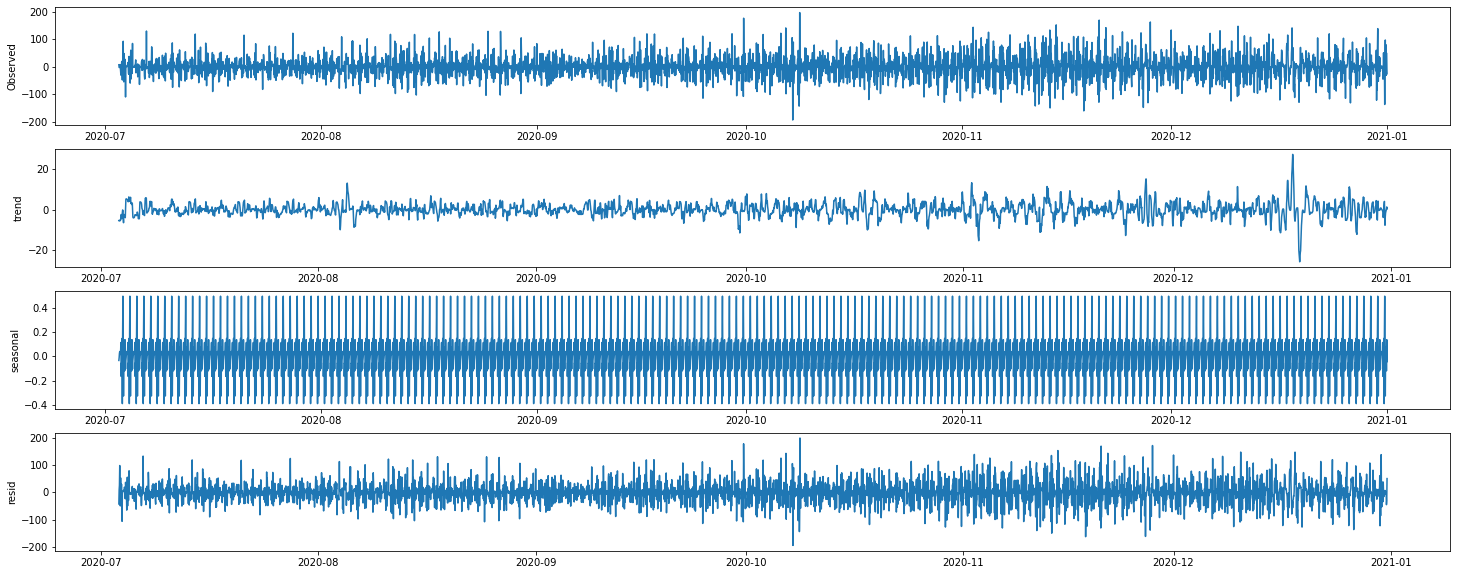

In [43]:
# сделаем два дифференцирования с 24 сдвигом. Затем еще на 1
data['reg_resid_diff'] = data.reg_resid - data.reg_resid.shift(24)
data['reg_resid_diff'] = data.reg_resid_diff - data.reg_resid_diff.shift(24)
data['reg_resid_diff'] = data.reg_resid_diff - data.reg_resid_diff.shift(1)


result = sm.tsa.seasonal_decompose(data.reg_resid_diff.dropna())
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(25,10))
axes[0].plot(result.observed)
axes[0].set(ylabel='Observed')
axes[1].plot(result.trend)
axes[1].set(ylabel='trend')
axes[2].plot(result.seasonal)
axes[2].set(ylabel='seasonal')
axes[3].plot(result.resid)  
axes[3].set(ylabel='resid') 
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.reg_resid_diff.dropna())[1])

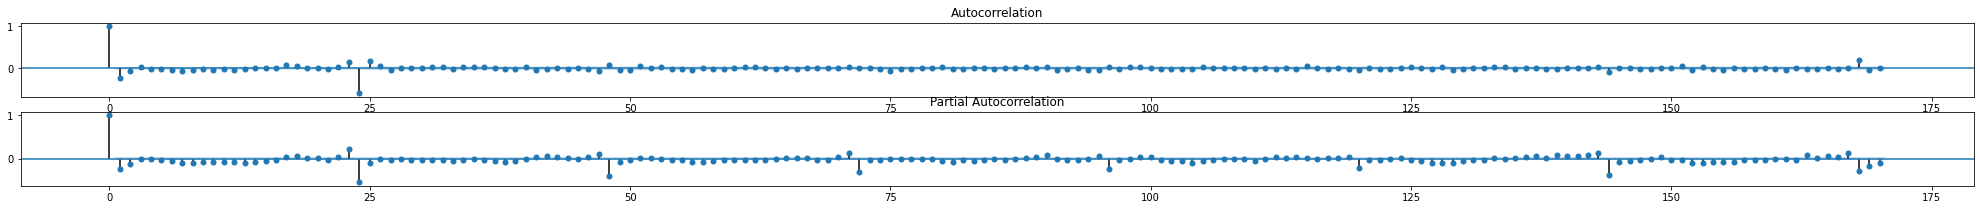

In [45]:
plt.figure(figsize=(35,3))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.reg_resid_diff.dropna().values.squeeze(), lags=170, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.reg_resid_diff.dropna().values.squeeze(), lags=170, ax=ax)
plt.show()

Оставим данные с полученной автокорреляцией.
Начальные приближения возьмем меньшие, чем нужно, из-за проблем с обучением. Даже google Colab завершался с ошибкой из-за перерасхода ОЗУ. А на ноутбуке совсем невозможно обучить.

In [46]:
# Начальное приближение
d=1
D=2
Qs = range(0, 2)
qs = range(0, 4)
Ps = range(0, 2)
ps = range(0, 3)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

48

In [ ]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
i=0
for param in parameters_list:
    print(i, '-', param, '...', datetime.datetime.now(), '...')
    i+=1
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.reg_resid, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

0 - (0, 0, 0, 0) ... 2021-06-06 12:34:12.384879 ...
1 - (0, 0, 0, 1) ... 2021-06-06 12:34:14.875879 ...
2 - (0, 0, 1, 0) ... 2021-06-06 12:35:36.606369 ...
3 - (0, 0, 1, 1) ... 2021-06-06 12:35:42.977397 ...
4 - (0, 1, 0, 0) ... 2021-06-06 12:38:26.279405 ...
5 - (0, 1, 0, 1) ... 2021-06-06 12:38:33.609478 ...
6 - (0, 1, 1, 0) ... 2021-06-06 12:42:26.979317 ...
7 - (0, 1, 1, 1) ... 2021-06-06 12:42:45.869552 ...
8 - (0, 2, 0, 0) ... 2021-06-06 12:44:40.252494 ...
9 - (0, 2, 0, 1) ... 2021-06-06 12:44:49.214934 ...
10 - (0, 2, 1, 0) ... 2021-06-06 12:50:08.600504 ...
11 - (0, 2, 1, 1) ... 2021-06-06 12:50:33.643020 ...
12 - (0, 3, 0, 0) ... 2021-06-06 12:52:55.953997 ...
13 - (0, 3, 0, 1) ... 2021-06-06 12:53:03.395573 ...
14 - (0, 3, 1, 0) ... 2021-06-06 12:59:43.404487 ...
15 - (0, 3, 1, 1) ... 2021-06-06 13:00:14.987087 ...
16 - (1, 0, 0, 0) ... 2021-06-06 13:03:30.316626 ...
17 - (1, 0, 0, 1) ... 2021-06-06 13:03:32.574042 ...
18 - (1, 0, 1, 0) ... 2021-06-06 13:07:01.275734 ...
19 

In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters           aic
47  (2, 3, 1, 1)  38946.186029
31  (1, 3, 1, 1)  38960.748978
7   (0, 1, 1, 1)  39316.021425
19  (1, 0, 1, 1)  39317.292909
35  (2, 0, 1, 1)  39317.405479


In [ ]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          reg_resid   No. Observations:                 4416
Model:             SARIMAX(2, 1, 3)x(1, 2, 1, 24)   Log Likelihood              -19465.093
Date:                            Sun, 06 Jun 2021   AIC                          38946.186
Time:                                    15:19:50   BIC                          38997.241
Sample:                                07-01-2020   HQIC                         38964.203
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1471      0.011    -13.647      0.000      -0.168      -0.126
ar.L2          0.8121      0.010   

In [ ]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          reg_resid   No. Observations:                 4416
Model:             SARIMAX(2, 1, 3)x(1, 2, 1, 24)   Log Likelihood              -19465.093
Date:                            Sun, 06 Jun 2021   AIC                          38946.186
Time:                                    15:20:35   BIC                          38997.241
Sample:                                07-01-2020   HQIC                         38964.203
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1471      0.011    -13.647      0.000      -0.168      -0.126
ar.L2          0.8121      0.010     82.978      0.000       0.793       0.831
ma.L1         -0.0814     24.465     -0.003      0.997     -48.032      47.869
ma.L2         -0.9996     22.471     -0.044      0.965     -45.042      43.043
ma.L3          0.0810      1.985      0.041      0.967      -3.810       3.972
ar.S.L24      -0.3159      0.012    -25.463      0.000      -0.340      -0.292
ma.S.L24      -0.9991      0.175     -5.693      0.000      -1.343      -0.655
sigma2       419.7749   1.03e+04      0.041      0.967   -1.97e+04    2.05e+04
===================================================================================
Ljung-Box (Q):                      487.03   Jarque-Bera (JB):               582.63
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.29   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Создаем лучшую модель ARIMA

In [ ]:
best_params = [2, 3, 1, 1]
d = 1
D = 2
model = sm.tsa.statespace.SARIMAX(data.reg_resid, order=(best_params[0], d, best_params[1]), 
                                        seasonal_order=(best_params[2], D, best_params[3], 24)).fit(disp=-1)

plt.figure(figsize=(25,8))
plt.subplot(211)
model.resid.dropna().plot(title='Остатки')
plt.ylabel(u'Residuals')

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(model.resid.dropna(), 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(model.resid.dropna())[1])
print('Критерий Льюнга-Бокса: p={}'.format(float(str(model.summary().tables[2]).split()[8])))


Построим график исходного ряда и предсказания модели поверх него.

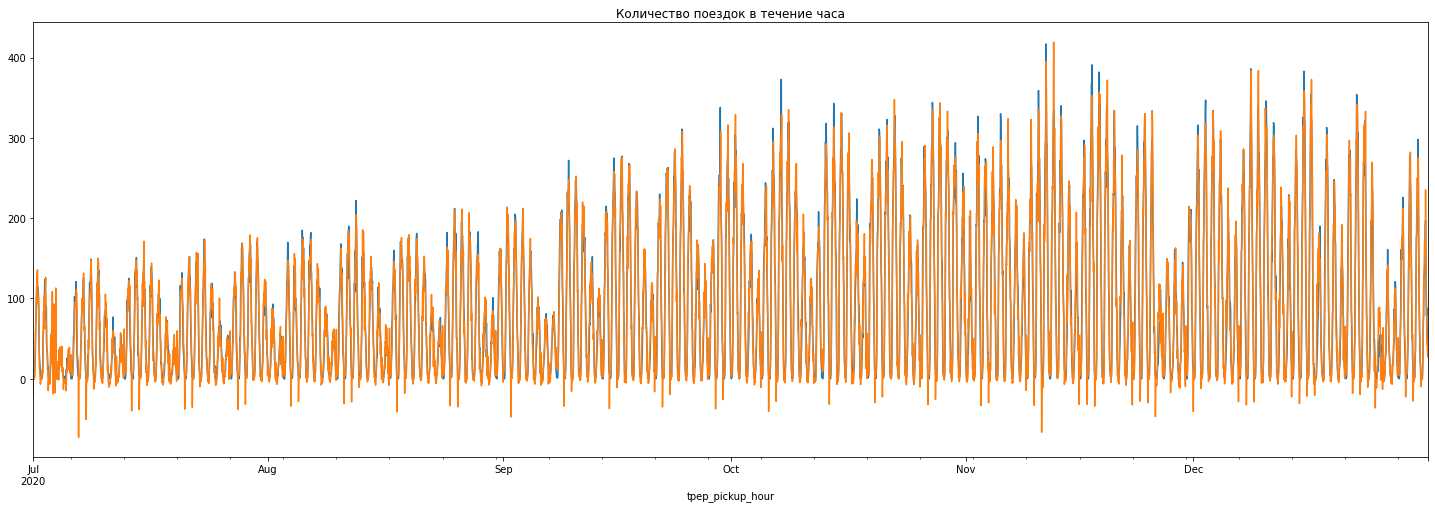

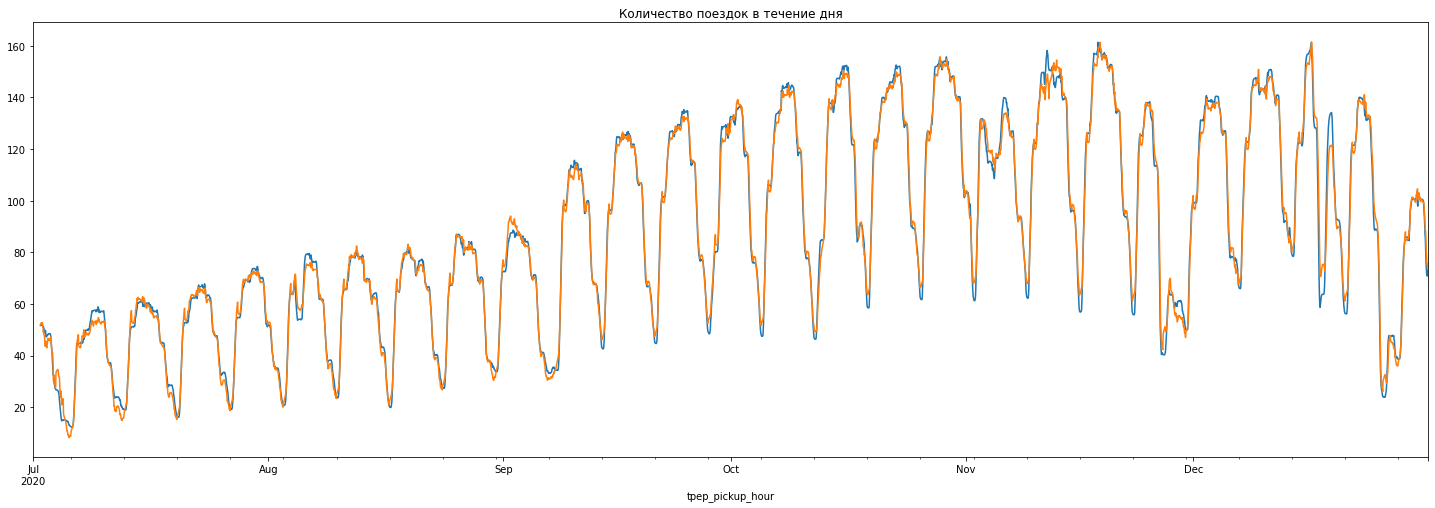

In [25]:
data['fitted_values'] = model.fittedvalues
data['resid'] = model.resid
data['pred'] = data['reg_pred'] +  data['fitted_values']
plt.figure(figsize=(25,8))
data.trips.plot(title='Количество поездок в течение часа')
data.pred.plot()
plt.show()
plt.figure(figsize=(25,8))
data.trips.rolling(24).mean().plot(title='Количество поездок в течение дня')
data.pred.rolling(24).mean().plot()
plt.show()

Более детально посмотрим на график за последний месяц

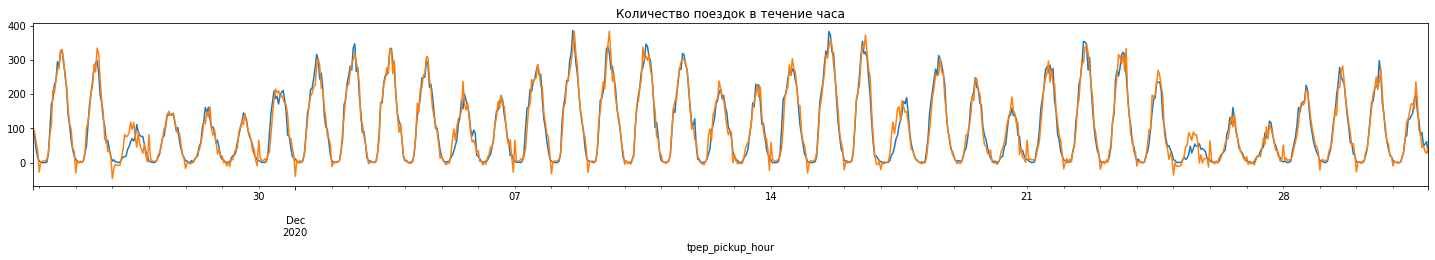

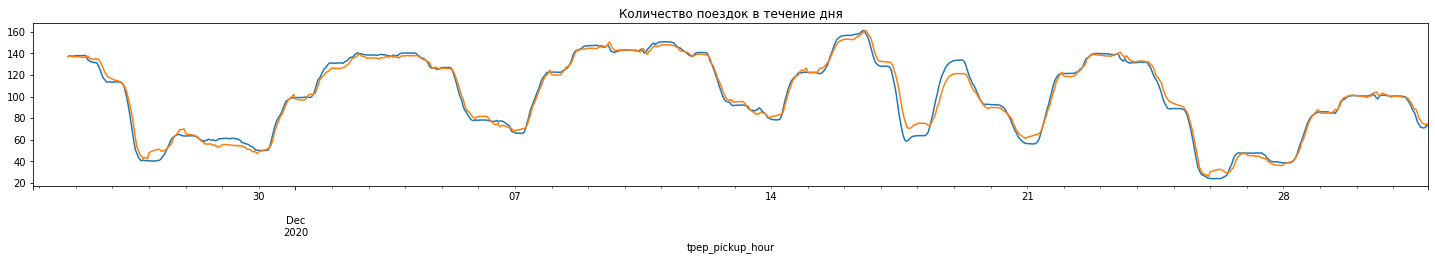

In [28]:
plt.figure(figsize=(25,3))
data.trips[3500:].plot(title='Количество поездок в течение часа')
data.pred[3500:].plot()
plt.show()
plt.figure(figsize=(25,3))
data.trips[3500:].rolling(24).mean().plot(title='Количество поездок в течение дня')
data.pred[3500:].rolling(24).mean().plot()
plt.show()

Модель может предсказывать значения менее 0, чего быть не может. Надо данные значения приравнивать к 0.
Визуально, модель довольно неплохо прогнозирует данные, на которых она обучалась.

